In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

### Figure 4 is based on several important BED-files ...

In [4]:
feat_names = OrderedDict()
feat_names["tss"] = "ActiveTSS-NO-CTCF-8849-1bp.bed"
feat_names["ddx55-nt"] = "NT-DDX55-NO-CTCF-no-activeTSS-NO-CTCF"
# feat_names["ddx55-iaa"] = "IAA-DDX55-NO-CTCF-narrowPeaks-new-no-activeTSS"
feat_names["taf5l-nt"] = "NT-TAF5L-NO-CTCF-no-activeTSS-NO-CTCF"
# feat_names["taf5l-iaa"] = "IAA-TAF5L-NO-CTCF-narrowPeaks-new-no-activeTSS"


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    if k != "tss":
        dfs[k] = bf.read_table(
            feat_names[k],
            names=["chrom","start","end"],
            usecols=(0,1,2),
            index_col=None
        )
        dfs[k] = dfs[k].sort_values(["chrom","start"])
        dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
        dfs[k] = dfs[k].reset_index(drop=True)
    else:
        dfs[k] = bf.read_table(
            feat_names[k],
            names=["chrom","start","end","strand"],
            usecols=(0,1,2,3),
            index_col=None
        )
        dfs[k] = dfs[k].sort_values(["chrom","start"])
        dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
        dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


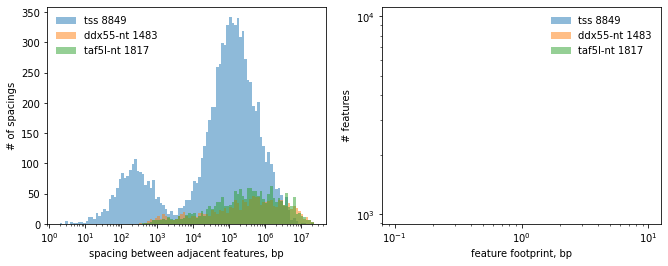

In [6]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [7]:
samples.keys()

dict_keys(['ctcf', 'noctcf', 'rad21_CTCF', 'rad21_noCTCF', 'rad21_wt1', 'rad21_rad21', 'rad21_norad21', 'G4a_r2', 'Rloop_K562', 'ddx_CTCF', 'ddx_noCTCF', 'taf5l_CTCF', 'taf5l_noCTCF', 'ddx_CTCF_r2', 'ddx_noCTCF_r2', 'taf5l_CTCF_r2', 'taf5l_noCTCF_r2', 'rad21_CTCF_r2', 'rad21_noCTCF_r2', 'input_CTCF_r2', 'input_noCTCF_r2', 'input_CTCF_r3', 'input_noCTCF_r3', 'input_CTCF', 'input_noCTCF', 'polII', 'h3k4_r1', 'h3k4_r2', 'h3k4_input', 'h3k4_k562', 'ins_CTCF', 'ins_noCTCF', 'ins_polII', 'ins_nopolII', 'ins_rad21', 'ins_norad21', 'ins_mutCtr_CTCF', 'ins_mutCtr_noCTCF', 'ins_mutDDX_CTCF', 'ins_mutDDX_noCTCF', 'ins_mutTAF_CTCF', 'ins_mutTAF_noCTCF', 'ins_siCtr_CTCF', 'ins_siCtr_noCTCF', 'ins_siDDX_CTCF', 'ins_siDDX_noCTCF', 'ins_siTAF_CTCF', 'ins_siTAF_noCTCF', 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII', 'ev1_rad21', 'ev1_norad21', 'ev1_mutCtr_CTCF', 'ev1_mutCtr_noCTCF', 'ev1_mutDDX_CTCF', 'ev1_mutDDX_noCTCF', 'ev1_mutTAF_CTCF', 'ev1_mutTAF_noCTCF', 'ev1_siCtr_CTCF', 'ev1_siCtr_noCTC

In [8]:
#let's describe our samples that we want to have in Figure 1 ...
fig5_samples = ["rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ddx_CTCF","ddx_noCTCF",'taf5l_CTCF','taf5l_noCTCF','h3k4_r1',"mrna_ctcf"]
#                 ,'input_CTCF','input_noCTCF']

titles = fig5_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig5_samples + ["rad21_CTCF_r2","rad21_noCTCF_r2","ddx_CTCF_r2","ddx_noCTCF_r2",'taf5l_CTCF_r2','taf5l_noCTCF_r2']:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [9]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    # here we'll be extracting more than we actually need for the stackups ...
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features tss:(8849) ...


stacking up rad21_CTCF ...
CPU times: user 1.79 s, sys: 194 ms, total: 1.98 s
Wall time: 1.97 s
stacking up rad21_noCTCF ...
CPU times: user 1.44 s, sys: 118 ms, total: 1.56 s
Wall time: 1.55 s
stacking up ins_CTCF ...
CPU times: user 1.23 s, sys: 66.1 ms, total: 1.3 s
Wall time: 1.3 s
stacking up ins_noCTCF ...
CPU times: user 1.21 s, sys: 95.9 ms, total: 1.3 s
Wall time: 1.3 s
stacking up ddx_CTCF ...
CPU times: user 1.69 s, sys: 131 ms, total: 1.83 s
Wall time: 1.82 s
stacking up ddx_noCTCF ...
CPU times: user 1.59 s, sys: 128 ms, total: 1.71 s
Wall time: 1.72 s
stacking up taf5l_CTCF ...
CPU times: user 1.47 s, sys: 63.9 ms, total: 1.53 s
Wall time: 1.54 s
stacking up taf5l_noCTCF ...
CPU times: user 1.39 s, sys: 84.1 ms, total: 1.47 s
Wall time: 1.47 s
stacking up h3k4_r1 ...
CPU times: user 1.74 s, sys: 86.2 ms, total: 1.83 s
Wall time: 1.85 s
stacking up mrna_ctcf ...
CPU times: user 1.08 s, sys: 56.1 ms, total: 1.13 s
Wall time: 1.14 s

In [10]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig5_samples.append(feat_name)
titles = fig5_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for tss ...
stacking genes up for ddx55-nt ...
stacking genes up for taf5l-nt ...


### flip according to the genes ...

In [11]:
flip_stackup_dict = OrderedDict()
for k in dfs:
    if k == "tss":
        # flippin separately for each set ...
        print(f"preparing to flip {k} ...")
        the_stackup = stackup_dict[k]
        # we'll be flipping according to gene orientation ....
        the_strand = dfs[k]["strand"]
        preflip_index = the_strand.index

        # flipped index according to EV1
        flip_stackup_index = np.concatenate([
            preflip_index[the_strand=="+"],
            preflip_index[the_strand=="-"],
            preflip_index[~the_strand.isin(["+","-"])] # don't forget to bring NaN-filled EVs back in
        ])

        assert (np.sort(flip_stackup_index) == preflip_index).all()

        # flip EVERYTHING according to the strand
        flip_stackups = {}
        for s in bw_fnames:
            flip_stackups[s] = np.concatenate([
                the_stackup[s][the_strand=="+"],
                (-1 if s=="gene" else 1) * the_stackup[s][the_strand=="-"][:,::-1],
                the_stackup[s][~the_strand.isin(["+","-"])] # keep NaN-filled items along unperturbed
            ])[np.argsort(flip_stackup_index)]
        # !!! Make sure rows in the stackups are re-sorted back the same way
        # ro ensure they are in sync with the input BED-files !

        # print flip condition numbers ...
        sum_p = (the_strand=="+").sum()
        sum_m = (the_strand=="-").sum()
        sum_n = (~the_strand.isin(["+","-"])).sum()

        print(f"initial number of items {len(the_strand)}, intact {sum_p}, flipped {sum_m} , NaN-filled {sum_n}")
        print(f"{sum_p} + {sum_m} + {sum_n} = {sum_p+sum_m+sum_n}")

        # save flipped the_stackup to the new OrderedDict ...
        flip_stackup_dict[k] = flip_stackups
    else:
        # save flipped the_stackup to the new OrderedDict ...
        flip_stackup_dict[k] = stackup_dict[k]


preparing to flip tss ...
initial number of items 8849, intact 4481, flipped 4368 , NaN-filled 0
4481 + 4368 + 0 = 8849


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [12]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in flip_stackup_dict:
    the_stackup = flip_stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [13]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.03)
    cmps[s] = cmapYlGnBu_r

In [14]:
# dat_nt = pd.DataFrame({"X":[],"Y1":[],"Y2":[],"Y3":[]})
# dat_iaa = pd.DataFrame({"X":[],"Y1":[],"Y2":[],"Y3":[]})

# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['rad21_CTCF'].shape
    center_bin = int(width/2)

    the_stackups['rad21_iaa_mean'] = np.nanmean(the_stackups['rad21_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['ddx_iaa_mean'] = np.nanmean(the_stackups['ddx_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['taf_iaa_mean'] = np.nanmean(the_stackups['taf5l_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    
    the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['ddx_mean'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['taf_mean'] = np.nanmean(the_stackups['taf5l_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    if feature_key.startswith("tss"):
        _sorting_key = "rad21_mean"
#         _dat_nt = pd.DataFrame({"X":the_stackups['rad21_mean'],"Y1":the_stackups['ddx_mean'],"Y2":the_stackups['taf_mean'],"Y3":the_stackups['input_mean']})
#         _dat_iaa = pd.DataFrame({"X":the_stackups['rad21_iaa_mean'],"Y1":the_stackups['ddx_iaa_mean'],"Y2":the_stackups['taf_iaa_mean'],"Y3":the_stackups['input_iaa_mean']})
#         dat_nt = pd.concat([dat_nt,_dat_nt])
#         dat_iaa = pd.concat([dat_iaa,_dat_iaa])
    elif feature_key.startswith("ddx"):
        _sorting_key = "ddx_mean"
    else:
        _sorting_key = "taf_mean"

    _, _jjj = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(the_stackups[_sorting_key]) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 8849 elements of rad21_mean into 1 groups ...
sorting 1483 elements of ddx_mean into 1 groups ...
sorting 1817 elements of taf_mean into 1 groups ...


#### plotting those running averages is integrated into `plot_stackups` function ...

In [21]:
feat_names.keys()

odict_keys(['tss', 'ddx55-nt', 'taf5l-nt'])

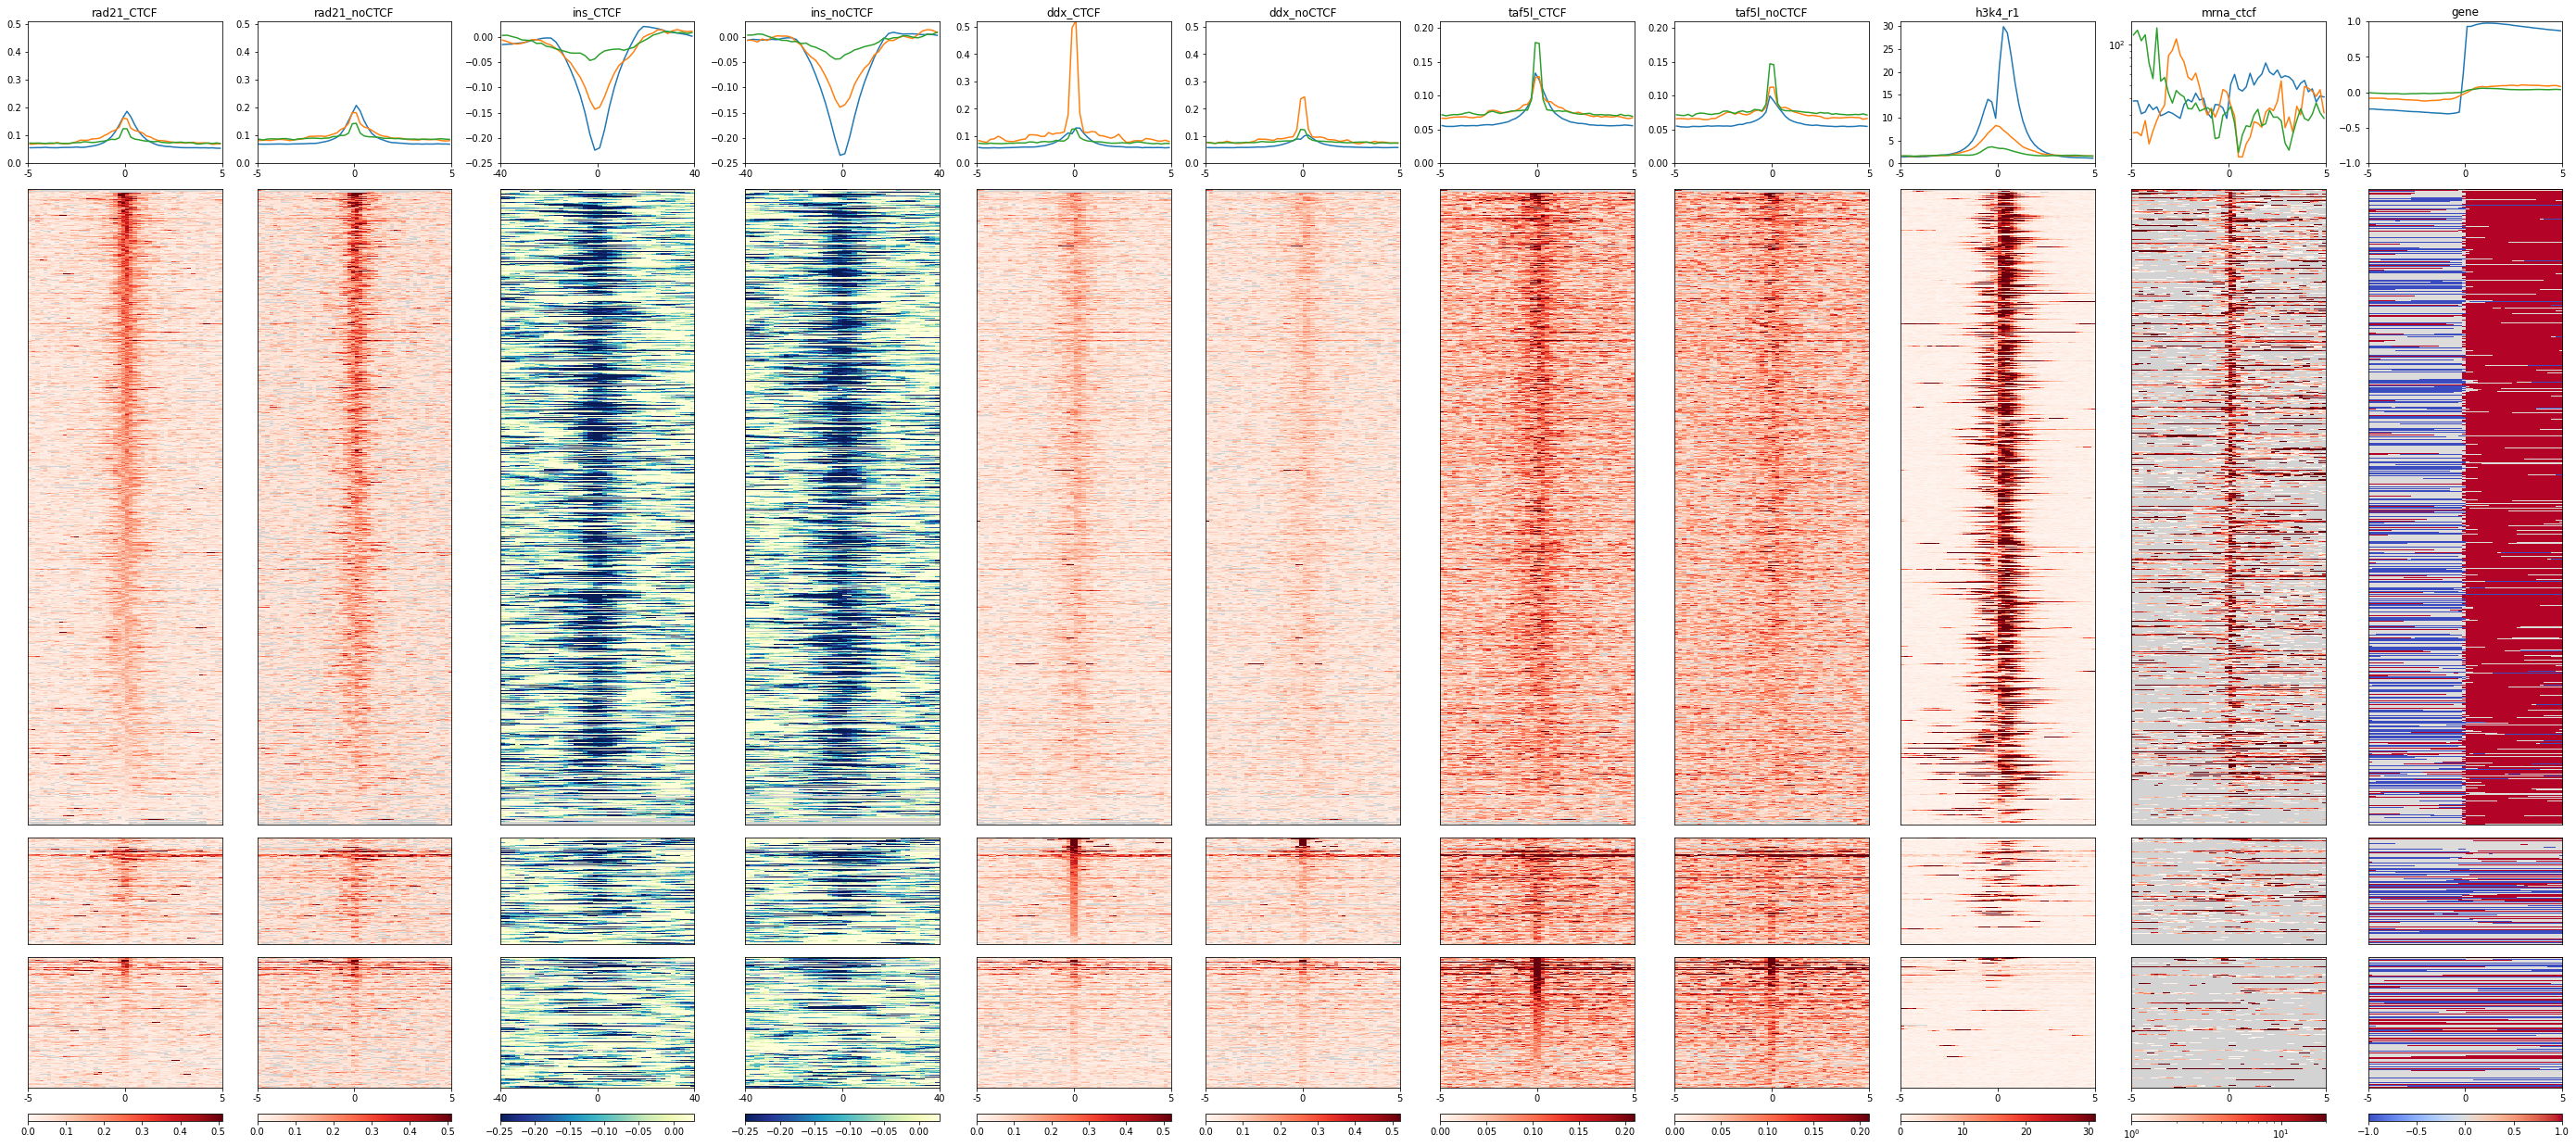

In [22]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig5_samples ]

_limss = [ limss[_k] for _k in fig5_samples ]
_cmps = [ cmps[_k] for _k in fig5_samples ]
_binsizes = [ binsizes[_k] for _k in fig5_samples ]
_norms = [ norms[_k] for _k in fig5_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group


plt.savefig("Fig5D-ddx-taf.pdf")

In [23]:
#### quantification:
# for 3 categories- we'll extract values in the middle of the stackup - for DDX and TAF (2 replicates) and RAD21(?)

In [24]:
flip_stackup_dict[feature_key].keys()

dict_keys(['rad21_CTCF', 'rad21_noCTCF', 'ins_CTCF', 'ins_noCTCF', 'ddx_CTCF', 'ddx_noCTCF', 'taf5l_CTCF', 'taf5l_noCTCF', 'h3k4_r1', 'mrna_ctcf', 'rad21_CTCF_r2', 'rad21_noCTCF_r2', 'ddx_CTCF_r2', 'ddx_noCTCF_r2', 'taf5l_CTCF_r2', 'taf5l_noCTCF_r2', 'gene', 'rad21_iaa_mean', 'ddx_iaa_mean', 'taf_iaa_mean', 'rad21_mean', 'ddx_mean', 'taf_mean'])

In [25]:
quantification_keys = [
                'rad21_iaa_mean_r1',
                'rad21_mean_r1',
                'rad21_iaa_mean_r2',
                'rad21_mean_r2',
                'ddx_iaa_mean_r1',
                'taf_iaa_mean_r1',
                'ddx_mean_r1',
                'taf_mean_r1',
                'ddx_iaa_mean_r2',
                'taf_iaa_mean_r2',
                'ddx_mean_r2',
                'taf_mean_r2',
]

quant_dfs_dict = {}

# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    # for  a given set of stackups for a given list of features ...
    length,width = the_stackups['rad21_CTCF'].shape
    center_bin = int(width/2)

    # replicate 1 RAD21 in CTCF-degron and degron+AUX
    the_stackups['rad21_iaa_mean_r1'] = np.nanmean(the_stackups['rad21_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rad21_mean_r1'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-1:center_bin+1],axis=1)
    
    the_stackups['rad21_iaa_mean_r2'] = np.nanmean(the_stackups['rad21_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rad21_mean_r2'] = np.nanmean(the_stackups['rad21_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)

    the_stackups['taf_iaa_mean_r1'] = np.nanmean(the_stackups['taf5l_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_mean_r1'] = np.nanmean(the_stackups['taf5l_CTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_iaa_mean_r2'] = np.nanmean(the_stackups['taf5l_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_mean_r2'] = np.nanmean(the_stackups['taf5l_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    
    if feature_key == "tss":
        # replicate 1, DDX and TAF in CTCF-degron and CTCF-degron+AUX
        the_stackups['ddx_iaa_mean_r1'] = np.nanmean(the_stackups['ddx_noCTCF'][:,center_bin:center_bin+2],axis=1)
        the_stackups['ddx_mean_r1'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin:center_bin+2],axis=1)
        # replicate 2, DDX and TAF in CTCF-degron and CTCF-degron+AUX
        the_stackups['ddx_iaa_mean_r2'] = np.nanmean(the_stackups['ddx_noCTCF_r2'][:,center_bin:center_bin+2],axis=1)
        the_stackups['ddx_mean_r2'] = np.nanmean(the_stackups['ddx_CTCF_r2'][:,center_bin:center_bin+2],axis=1)
    else:
        # replicate 1, DDX and TAF in CTCF-degron and CTCF-degron+AUX
        the_stackups['ddx_iaa_mean_r1'] = np.nanmean(the_stackups['ddx_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
        the_stackups['ddx_mean_r1'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin-1:center_bin+1],axis=1)
        # replicate 2, DDX and TAF in CTCF-degron and CTCF-degron+AUX
        the_stackups['ddx_iaa_mean_r2'] = np.nanmean(the_stackups['ddx_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
        the_stackups['ddx_mean_r2'] = np.nanmean(the_stackups['ddx_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    
    quant_dfs_dict[feature_key] = pd.DataFrame({ k:the_stackups[k]  for k in quantification_keys })

    

In [26]:
# let's calcuate fold changes for the interesting cases ...

dat = {}
dat["tss-rad21-1"] = (quant_dfs_dict["tss"]['rad21_iaa_mean_r1'] / quant_dfs_dict["tss"]['rad21_mean_r1'])
dat["tss-rad21-2"] = (quant_dfs_dict["tss"]['rad21_iaa_mean_r2'] / quant_dfs_dict["tss"]['rad21_mean_r2'])
dat["tss-ddx-1"] = (quant_dfs_dict["tss"]['ddx_iaa_mean_r1'] / quant_dfs_dict["tss"]['ddx_mean_r1'])
dat["tss-ddx-2"] = (quant_dfs_dict["tss"]['ddx_iaa_mean_r2'] / quant_dfs_dict["tss"]['ddx_mean_r2'])
dat["tss-taf-1"] = (quant_dfs_dict["tss"]['taf_iaa_mean_r1'] / quant_dfs_dict["tss"]['taf_mean_r1'])
dat["tss-taf-2"] = (quant_dfs_dict["tss"]['taf_iaa_mean_r2'] / quant_dfs_dict["tss"]['taf_mean_r2'])

dat["ddx-rad21-1"] = (quant_dfs_dict["ddx55-nt"]['rad21_iaa_mean_r1'] / quant_dfs_dict["ddx55-nt"]['rad21_mean_r1'])
dat["ddx-rad21-2"] = (quant_dfs_dict["ddx55-nt"]['rad21_iaa_mean_r2'] / quant_dfs_dict["ddx55-nt"]['rad21_mean_r2'])
dat["ddx-ddx-1"] = (quant_dfs_dict["ddx55-nt"]['ddx_iaa_mean_r1'] / quant_dfs_dict["ddx55-nt"]['ddx_mean_r1'])
dat["ddx-ddx-2"] = (quant_dfs_dict["ddx55-nt"]['ddx_iaa_mean_r2'] / quant_dfs_dict["ddx55-nt"]['ddx_mean_r2'])
dat["ddx-taf-1"] = (quant_dfs_dict["ddx55-nt"]['taf_iaa_mean_r1'] / quant_dfs_dict["ddx55-nt"]['taf_mean_r1'])
dat["ddx-taf-2"] = (quant_dfs_dict["ddx55-nt"]['taf_iaa_mean_r2'] / quant_dfs_dict["ddx55-nt"]['taf_mean_r2'])

dat["taf-rad21-1"] = (quant_dfs_dict["taf5l-nt"]['rad21_iaa_mean_r1'] / quant_dfs_dict["taf5l-nt"]['rad21_mean_r1'])
dat["taf-rad21-2"] = (quant_dfs_dict["taf5l-nt"]['rad21_iaa_mean_r2'] / quant_dfs_dict["taf5l-nt"]['rad21_mean_r2'])
dat["taf-ddx-1"] = (quant_dfs_dict["taf5l-nt"]['ddx_iaa_mean_r1'] / quant_dfs_dict["taf5l-nt"]['ddx_mean_r1'])
dat["taf-ddx-2"] = (quant_dfs_dict["taf5l-nt"]['ddx_iaa_mean_r2'] / quant_dfs_dict["taf5l-nt"]['ddx_mean_r2'])
dat["taf-taf-1"] = (quant_dfs_dict["taf5l-nt"]['taf_iaa_mean_r1'] / quant_dfs_dict["taf5l-nt"]['taf_mean_r1'])
dat["taf-taf-2"] = (quant_dfs_dict["taf5l-nt"]['taf_iaa_mean_r2'] / quant_dfs_dict["taf5l-nt"]['taf_mean_r2'])

In [27]:
hist_samples = [
                "tss-rad21",
                "tss-ddx",
                "tss-taf",
                "ddx-rad21",
                "ddx-ddx",
                "ddx-taf",
                "taf-rad21",
                "taf-ddx",
                "taf-taf"]

dict_keys(['tss', 'ddx55-nt', 'taf5l-nt'])


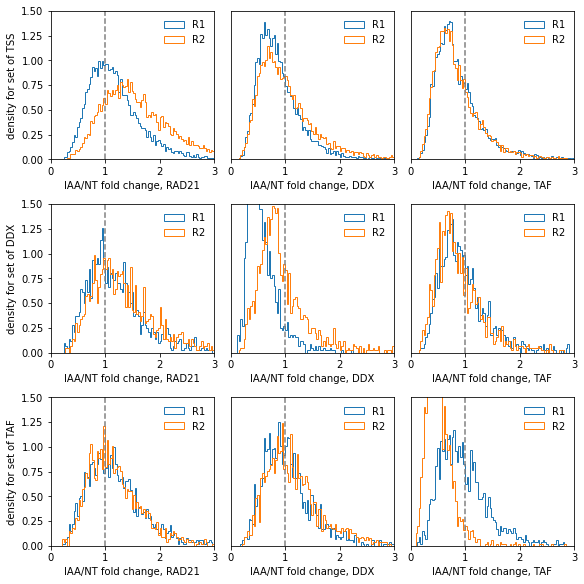

In [31]:
print(quant_dfs_dict.keys())

fig = plt.figure(figsize=(8,8), constrained_layout=True)
gsp = fig.add_gridspec(3,3)

bins = np.linspace(0,3,100)
# bins = np.linspace(-1,1,100)
for idx,s in enumerate(hist_samples):
#     if i < 1:
    i = idx//3
    j = idx%3
    loci,signal_name = s.split("-")
    ax = fig.add_subplot(gsp[i,j])
    ax.hist(dat[s+"-1"],bins=bins,cumulative=False,density=True,histtype="step",label="R1")
    ax.hist(dat[s+"-2"],bins=bins,cumulative=False,density=True,histtype="step",label="R2")
    ax.axvline(1,color="grey",linestyle="--")
    ax.set_xlim(0,3)
    ax.set_ylim(0,1.5)
    ax.legend(frameon=False)
    ax.set_xlabel(f"IAA/NT fold change, {signal_name.upper()}")
    if j ==0:
        ax.set_ylabel(f"density for set of {loci.upper()}")
    if j>0:
        ax.set_yticks([])
        ax.set_yticklabels([])

        
plt.savefig("Fig5E-DDX-TAF-signal-quantification.pdf")

In [32]:
!scp Fig5E-DDX-TAF-signal-quantification.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig5E-DDX-TAF-signal-quantification.pdf       100%  389KB 269.9KB/s   00:01    


In [30]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp Fig4-ddf-taf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
!scp Fig5D-ddx-taf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig5D-ddx-taf.pdf                             100% 1465KB 342.1KB/s   00:04    
